In [24]:
import sympy
import argparse
import numpy as np
import pickle
import sys
import os
from pathlib import Path

import matplotlib.pyplot as plt

import equations
import data
from derivative import dxdt

from gplearn.genetic import SymbolicRegressor
from utils import generator

In [25]:
from pathlib import Path

def load_results(path_base: Path, x_id: int = 0, seed_s: int = 0, seed_e: int = 1):
    res_list = []
    for s in range(seed_s, seed_e):
        if x_id == 0:
            path = path_base / f"grad_seed_{s}.pkl"
        else:
            path = path_base / f"grad_x_{x_id}_seed_{s}.pkl"

        try:
            with open(path, "rb") as f:
                res = pickle.load(f)
            res_list.append(res)
        except FileNotFoundError:
            pass   
    return res_list


In [26]:
ode_name = "GompertzODE"
noise_sigma = 0.01
n_sample = 50
freq = 10
x_id = 0
seed_s = 0
seed_e = 1

path_base = Path(f"results/{ode_name}/noise-{noise_sigma}/sample-{n_sample}/freq-{freq}/")

res_list = load_results(path_base, x_id = x_id, seed_s = seed_s, seed_e = seed_e)

len(res_list)

1

In [27]:
path_base = Path(f"results_vi/{ode_name}/noise-{noise_sigma}/sample-{n_sample}/freq-{freq}/")

res_list_vi = load_results(path_base, x_id = x_id, seed_s = seed_s, seed_e = seed_e)

len(res_list_vi)

1

In [31]:
ode_true = res_list[0]
print(ode_true)

{'model': <gplearn._program._Program object at 0x157f5cbc0>, 'X_train': array([[0.01052971],
       [0.00798161],
       [0.00118547],
       ...,
       [0.65695695],
       [0.6581604 ],
       [0.65629451]]), 'y_train': array([ 0.06538956,  0.03836167,  0.00715802, ...,  0.0056707 ,
       -0.00629504,  0.02038583]), 'seed': 0, 'correct': False, 'f_hat': -X0*(X0**2 + log(X0)), 'ode': <equations.GompertzODE object at 0x157f575c0>, 'noise_ratio': 0.01, 'noise_sigma': 0.0023405202469895243, 'dg': <data.DataGenerator object at 0x157f6de20>, 'time': 83.08147668838501}


In [32]:
ode_true = res_list[0]['ode']
print('ode_true')
print(ode_true)
print(np.shape(ode_true))

f_hat = res_list[0]['model'].execute
print('f_hat')
print(f_hat)
print(np.shape(f_hat))

dg_true = data.DataGenerator(ode_true, ode_true.T, freq=10, n_sample=100, noise_sigma=0., init_high=ode_true.init_high, init_low=ode_true.init_low)
xt_true = dg_true.xt
print('xt_true')
print(xt_true)
print(np.shape(xt_true))

xt_true = xt_true.reshape(xt_true.shape[0] * xt_true.shape[1], xt_true.shape[2])
print(xt_true)
print(np.shape(xt_true))

dxdt_hat = f_hat(xt_true).flatten()
print(dxdt_hat)
print(np.shape(dxdt_hat))

x_in = [xt_true[:, i] for i in range(xt_true.shape[1])]
print(x_in)
print(np.shape(x_in))

dxdt_true = ode_true._dx_dt(*x_in)[x_id]
print(dxdt_true)
print(np.shape(dxdt_true))

rmse = np.sqrt(np.mean((dxdt_hat - dxdt_true) ** 2))
print(rmse)
print(np.shape(rmse))


ode_true
()
f_hat
<bound method _Program.execute of <gplearn._program._Program object at 0x157f5cbc0>>
()
xt_true
[[[0.0054183 ]
  [0.00903338]
  [0.00882845]
  ...
  [0.00378295]
  [0.00797883]
  [0.00548303]]

 [[0.0105923 ]
  [0.01644585]
  [0.01612421]
  ...
  [0.00777483]
  [0.01477932]
  [0.01070112]]

 [[0.01886096]
  [0.02754337]
  [0.02707909]
  ...
  [0.01445349]
  [0.02512341]
  [0.01902762]]

 ...

 [[0.65601744]
  [0.65714042]
  [0.65709   ]
  ...
  [0.65522934]
  [0.65686741]
  [0.65604351]]

 [[0.65749052]
  [0.65845915]
  [0.65841567]
  ...
  [0.65681059]
  [0.65822367]
  [0.657513  ]]

 [[0.65876099]
  [0.65959631]
  [0.65955881]
  ...
  [0.65817462]
  [0.6593932 ]
  [0.65878038]]]
(41, 100, 1)
[[0.0054183 ]
 [0.00903338]
 [0.00882845]
 ...
 [0.65817462]
 [0.6593932 ]
 [0.65878038]]
(4100, 1)
[ 0.0282724   0.04251783  0.04175589 ... -0.00981262 -0.01210917
 -0.01095323]
(4100,)
[array([0.0054183 , 0.00903338, 0.00882845, ..., 0.65817462, 0.6593932 ,
       0.65878038])

In [11]:
T, B, D = res_list[0]["dg"].xt.shape
#print(res_list[0]['dg'])
#print(T, B, D)

41 50 1


In [18]:
b = 2

x_true = res_list[0]["dg"].xt[:, b, 0]
print(x_true)
print(np.shape(x_true))
x_noise = res_list[0]["dg"].yt[:, b, 0]
print(x_noise)
print(np.shape(x_noise))
x_hat = res_list_vi[0]["ode_data"]["x_hat"][:, b, 0]
print(x_hat)
print(np.shape(x_hat))
t = res_list[0]["dg"].solver.t
print(t)
print(np.shape(t))

[0.00119111 0.00287556 0.00614007 0.01179601 0.02069183 0.03356346
 0.05089486 0.07282759 0.09913821 0.12927912 0.16246403 0.19777178
 0.23424746 0.27098547 0.30718784 0.34219722 0.37550868 0.40676534
 0.43574372 0.46233348 0.48651491 0.50833845 0.52790452 0.5453472
 0.56082105 0.57449066 0.5865227  0.59708037 0.60631949 0.61438607
 0.62141492 0.62752906 0.63283969 0.63744657 0.64143861 0.64489461
 0.64788411 0.65046831 0.65270079 0.65462838 0.65629201]
(41,)
[0.00118547 0.00175735 0.00314239 0.01360442 0.02451615 0.03204313
 0.05296638 0.07340741 0.09650723 0.12927587 0.16248389 0.19625451
 0.23375906 0.2691999  0.30806001 0.34076515 0.37722826 0.40617138
 0.44101081 0.46056258 0.48322492 0.50854696 0.52826615 0.54280161
 0.56307176 0.5738697  0.59129715 0.59419561 0.60467942 0.6154947
 0.62182656 0.6266868  0.63436246 0.63795701 0.64040361 0.64210307
 0.6492953  0.64956909 0.65315257 0.65309953 0.65629817]
(41,)
[0.00251482 0.00278402 0.00346429 0.00471157 0.00669626 0.0095416
 0.013

In [19]:
y_hat = res_list[0]["y_train"].reshape(T - 1, B)[:, b]
print(y_hat)
print(np.shape(y_hat))
y_hat_spline = dxdt(x_noise, t, kind="spline", s=0.012)[:-1]
print(y_hat_spline)
print(np.shape(y_hat_spline))
y_hat_direct = dxdt(x_noise, t, kind="spline", s=0.005)[:-1]
print(y_hat_direct)
print(np.shape(y_hat_direct))
y_true = res_list[0]["ode"]._dx_dt(x_true)[0][:-1]
print(y_true)
print(np.shape(y_true))

[0.00715802 0.01872698 0.049822   0.08300727 0.10973779 0.14694375
 0.19139228 0.23334723 0.279125   0.31844328 0.34285199 0.35906843
 0.36789915 0.36930453 0.36192911 0.34881284 0.33032801 0.30521751
 0.27058377 0.23960521 0.22591874 0.21030356 0.18802425 0.17091397
 0.15276264 0.13073451 0.10554088 0.08907686 0.08714381 0.07974485
 0.06760119 0.05861108 0.0482437  0.03638096 0.03138595 0.03372962
 0.03139266 0.02425471 0.01933308 0.01812267]
(40,)
[ 0.10562029  0.13303034  0.15831157  0.181464    0.20248761  0.22138241
  0.2381484   0.25278558  0.26529394  0.2756735   0.28392424  0.29004617
  0.29403928  0.29590359  0.29563908  0.29324576  0.28872363  0.28207269
  0.27329293  0.26238436  0.24934698  0.23503724  0.22031158  0.20517001
  0.18961253  0.17363912  0.15724981  0.14044458  0.12322343  0.10558638
  0.0875334   0.06906451  0.05017971  0.03087899  0.01116236 -0.00897018
 -0.02951864 -0.05048302 -0.07186331 -0.09365951]
(40,)
[ 0.03714144  0.07700738  0.11379377  0.14750062  0.

In [21]:
ode_name = "GompertzODE"
noise_sigma = 0.02
n_sample = 50
freq = 10
x_id = 0
seed_s = 0
seed_e = 1

path_base = Path(f"results/{ode_name}/noise-{noise_sigma}/sample-{n_sample}/freq-{freq}/")

res_list2 = load_results(path_base, x_id = x_id, seed_s = seed_s, seed_e = seed_e)

print(len(res_list2))

path_base = Path(f"results_vi/{ode_name}/noise-{noise_sigma}/sample-{n_sample}/freq-{freq}/")

res_list2_vi = load_results(path_base, x_id = x_id, seed_s = seed_s, seed_e = seed_e)

print(len(res_list2_vi))

1
1


In [22]:
T, B, D = res_list2[0]["dg"].xt.shape

b = 2

x_true2 = res_list2[0]["dg"].xt[:, b, 0]
x_noise2 = res_list2[0]["dg"].yt[:, b, 0]
x_hat2 = res_list2_vi[0]["ode_data"]["x_hat"][:, b, 0]
t2 = res_list2[0]["dg"].solver.t

y_hat2 = res_list2[0]["y_train"].reshape(T - 1, B)[:, b]
y_hat_spline2 = dxdt(x_noise2, t2, kind="spline", s=0.001)
y_hat_direct2 = dxdt(x_noise2, t2, kind="spline", s=0.00)
y_true2 = res_list2[0]["ode"]._dx_dt(x_true2)[0][:-1]

<>:36: SyntaxWarning: invalid escape sequence '\d'
<>:36: SyntaxWarning: invalid escape sequence '\d'
/var/folders/y_/d9skplf930bcv4p3z5fvnb7w0000gn/T/ipykernel_29710/487710754.py:36: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(t[:-1], y_true, label="${\dot{X}}(t)$")


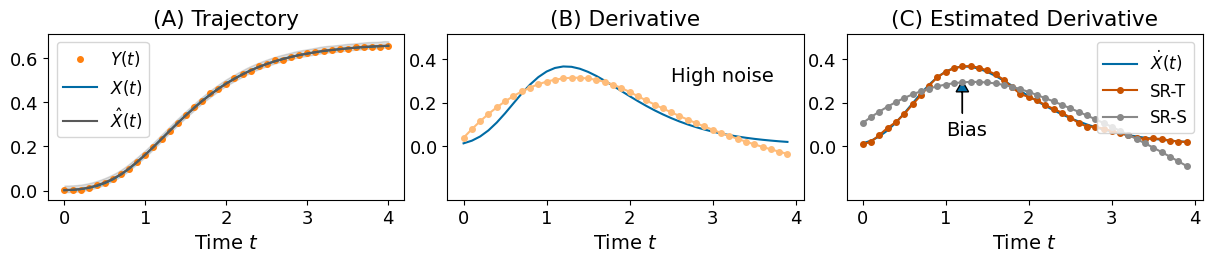

In [23]:
plt.figure(figsize=(12, 2.5))
plt.style.use("tableau-colorblind10")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.rcParams["font.size"] = "13"

plt.subplot(131)
plt.fill_between(
    res_list_vi[0]["t_new"], x_hat - 0.01, x_hat + 0.02, alpha=0.2, color=colors[3]
)
plt.plot(t, x_noise, "o", ms=4, label=r"$Y(t)$", color=colors[1])
plt.plot(t, x_true, label=r"$X(t)$", color=colors[0])
plt.plot(
    res_list_vi[0]["t_new"][::2],
    x_hat[::2],
    "-",
    ms=4,
    label=r"$\hat{X}(t)$",
    color=colors[3],
)
# plt.ylabel('Trajectory', fontsize=14)
plt.xlabel(r"Time $t$", fontsize=14)
plt.title("(A) Trajectory")
plt.legend(fontsize=12)

plt.subplot(132)
plt.plot(t[:-1], y_true, label=r"$\dot{X}(t)$ True")
plt.plot(t[:-1], y_hat_direct, "o-", ms=4, label=r"${\dot{X}}(t)$ TV", color=colors[8])
# plt.ylabel('Derivative', fontsize=14)
plt.yticks([0.0, 0.2, 0.4])
plt.xlabel(r"Time $t$", fontsize=14)
plt.ylim((-0.25, 0.52))
plt.text(s="High noise", x=2.5, y=0.3, color="black", fontsize=14)
plt.title("(B) Derivative")

plt.subplot(133)
plt.plot(t[:-1], y_true, label="${\dot{X}}(t)$")
plt.plot(t[:-1], y_hat, "o-", ms=4, label=r"SR-T", color=colors[5])
plt.plot(t[:-1], y_hat_spline, "o-", ms=4, label=r"SR-S", color=colors[6])
# plt.ylabel('Derivative', fontsize=14)
plt.yticks([0.0, 0.2, 0.4])
plt.xlabel(r"Time $t$", fontsize=14)
plt.ylim((-0.25, 0.52))
# plt.axvline(x=0, linestyle='--', color='black')
# plt.axvline(x=1.5, linestyle='--', color='black')
plt.text(s="Bias", x=1.0, y=0.05, color="black", fontsize=14)
plt.arrow(
    1.2, 0.15, 0.0, 0.15, head_length=0.05, head_width=0.15, length_includes_head=True
)
plt.legend(fontsize=12)
plt.title("(C) Estimated Derivative")


plt.tight_layout(pad=0.2)

plt.savefig(fname="Gompertz_plot.png", dpi=200)